### Multiclass Classification Using QuantumModel in FastQML

This demonstration highlights the application of a QuantumModel class standing for a Quantum Neural Network (QNN) Classifier in the FastQML framework, emphasizing the seamless integration and intuitive usability of FastQML for quantum machine learning (QML) model development. By leveraging the unique capabilities of quantum computing, the QuantumModel is employed to tackle a multiclass classification challenge. The primary goal of this notebook is to illustrate the straightforward process of setting up, training, and evaluating FastQML's models for a practical classification scenario, showcasing FastQML's effectiveness and user-friendly approach to implementing QML models.

In [2]:
## Project imports
import optax
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from fast_qml.quantum_circuits.data_encoding import AngleEmbedding
from fast_qml.quantum_circuits.ansatz import EfficientSU2
from fast_qml.quantum_circuits.ansatz import StronglyEntanglingLayers
from fast_qml.core.estimator import Estimator
from fast_qml.core.estimator import QuantumModel
from fast_qml.core.callbacks import EarlyStopping

## Project constants
QUBITS_N = 4
LEARNING_RATE = 0.05
EPOCHS_NUM = 150
RANDOM_SEED = 42
TEST_SIZE = 0.3
ES_PATIENCE = 25
LABELS= ['setosa', 'versicolor', 'virginica']

The dataset used in this demonstration is the Iris dataset, a classic dataset in machine learning and statistics. It consists of 150 samples of iris flowers from three different species. Each sample has four features: the length and the width of the sepals and petals.

The preprocessing steps include:
- Normalizing the feature data to ensure effective training of the neural network.
- Splitting the dataset into training, validation, and testing sets for a comprehensive evaluation.

In [3]:
# Load the iris dataset
data = load_iris()
X, y = data.data, data.target

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)
X, y = X.astype(np.float32), y.astype(np.int16)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

print(X_train.shape, X_test.shape, X_val.shape)

(105, 4) (14, 4) (31, 4)


The setup for the Quantum Neural Network includes:
- Defining the number of qubits, which corresponds to the number of features in the dataset.
- Choosing a feature map to encode classical data into quantum states.
- Selecting an ansatz (variational form) which defines the structure of the quantum circuit used in the neural network.

For the purpose of the demonstration AngleEmbedding feature map will be used with EfficientSU2 variational form.

In [4]:
# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=QUBITS_N
)

# EfficientSU2 ansatz instance with 'full' entanglement scheme
ansatz = EfficientSU2(
    n_qubits=QUBITS_N,
    entanglement='full',
    skip_last_rotations=False
)

# QuantumModel instance with defined ansatz and feature map
q_model = QuantumModel(
    n_qubits=QUBITS_N,
    feature_map=feature_map,
    ansatz=ansatz,
    layers_num=2,
    measurements_num=3,
    data_reuploading=False
)

# Draw quantum model circuit
q_model.draw_circuit(device_expansion=False)

0: ─╭AngleEmbedding(M0)──RY(0.07)──RX(-0.02)─╭●─╭●─╭●───────────||──RY(0.04)───RX(-0.21)──||
1: ─├AngleEmbedding(M0)──RY(0.04)──RX(0.10)──╰X─│──│──╭●─╭●─────||──RY(0.30)───RX(0.07)───||
2: ─├AngleEmbedding(M0)──RY(0.02)──RX(-0.06)────╰X─│──╰X─│──╭●──||──RY(-0.03)──RX(0.13)───||
3: ─╰AngleEmbedding(M0)──RY(0.01)──RX(0.04)────────╰X────╰X─╰X──||──RY(-0.05)──RX(-0.01)──||

───RY(-0.15)──RX(0.15)─╭●─╭●─╭●───────────||──RY(0.10)───RX(0.12)───||─┤  <Z>
───RY(-0.10)──RX(0.20)─╰X─│──│──╭●─╭●─────||──RY(0.15)───RX(-0.02)──||─┤  <Z>
───RY(-0.03)──RX(0.04)────╰X─│──╰X─│──╭●──||──RY(-0.09)──RX(0.03)───||─┤  <Z>
───RY(0.00)───RX(0.12)───────╰X────╰X─╰X──||──RY(-0.11)──RX(-0.05)──||─┤     


Having all components let's create an Estimator instance with defined QuantumModel as estimator component

In [5]:
# Create Estimator model with defined QuantumModel component
model = Estimator(
    estimator_components=q_model,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adam
)

Now we can fit the model, with validation and early stopping mechanism.

In [6]:
early_stopping = EarlyStopping(patience=ES_PATIENCE)

model.fit(
    train_data=X_train,
    train_targets=y_train,
    val_data=X_val,
    val_targets=y_val,
    num_epochs=EPOCHS_NUM,
    learning_rate=LEARNING_RATE,
    batch_size=len(y_train),
    early_stopping=early_stopping
)

Epoch 1/150 - train_loss: 1.13201 - val_loss: 1.08185
Epoch 2/150 - train_loss: 1.10406 - val_loss: 1.05560
Epoch 3/150 - train_loss: 1.07789 - val_loss: 1.02804
Epoch 4/150 - train_loss: 1.05399 - val_loss: 1.00139
Epoch 5/150 - train_loss: 1.03218 - val_loss: 0.97786
Epoch 6/150 - train_loss: 1.01184 - val_loss: 0.95644
Epoch 7/150 - train_loss: 0.99217 - val_loss: 0.93629
Epoch 8/150 - train_loss: 0.97306 - val_loss: 0.91648
Epoch 9/150 - train_loss: 0.95445 - val_loss: 0.89977
Epoch 10/150 - train_loss: 0.93848 - val_loss: 0.88345
Epoch 11/150 - train_loss: 0.92274 - val_loss: 0.86902
Epoch 12/150 - train_loss: 0.90903 - val_loss: 0.85383
Epoch 13/150 - train_loss: 0.89507 - val_loss: 0.83948
Epoch 14/150 - train_loss: 0.88116 - val_loss: 0.82401
Epoch 15/150 - train_loss: 0.86514 - val_loss: 0.80983
Epoch 16/150 - train_loss: 0.84867 - val_loss: 0.79473
Epoch 17/150 - train_loss: 0.82992 - val_loss: 0.78117
Epoch 18/150 - train_loss: 0.81282 - val_loss: 0.76592
Epoch 19/150 - trai

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.33      0.50         6
           2       0.56      1.00      0.71         5

    accuracy                           0.71        14
   macro avg       0.85      0.78      0.74        14
weighted avg       0.84      0.71      0.68        14


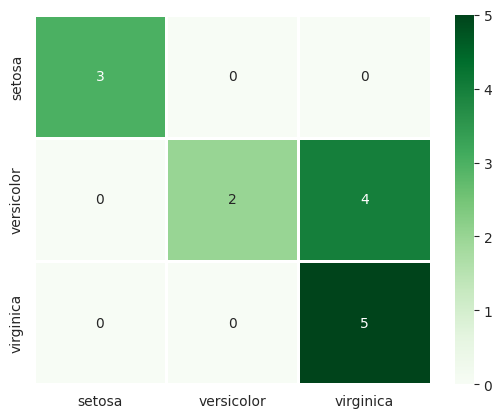

In [7]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(cm, cmap="Greens", linewidths=0.8, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

We have successfully trained a pretty decent Quantum Neural Network using a straightforward and efficient approach. Our next objective is to further enhance the performance and efficiency of our QNN. To achieve this, we will be implementing the data reuploading technique. We will also use [StronglyEntanglingLayers](https://arxiv.org/abs/1804.00633), inspired by the circuit-centric classifier design.

Data reuploading is a powerful strategy that allows for repeated encoding of classical data into quantum states within a single quantum circuit. This technique effectively enhances the capacity of the quantum model to capture complex patterns and relationships in the data, leading to potentially improved performance in tasks like classification and regression.

In [8]:
# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=QUBITS_N
)

# StronglyEntanglingLayers ansatz with 3 layers
ansatz = StronglyEntanglingLayers(
    n_qubits=QUBITS_N,
    n_layers=2
)

# Create QuantumModel model with defined ansatz and feature map
# Use data reuploading technique by setting data_reuploading to True
q_model = QuantumModel(
    n_qubits=QUBITS_N,
    feature_map=feature_map,
    ansatz=ansatz,
    data_reuploading=True,
    layers_num=2,
    measurements_num=3
)

q_model.draw_circuit(device_expansion=False)

0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)──||─╭AngleEmbedding(M0)
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)──||─├AngleEmbedding(M0)
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)──||─├AngleEmbedding(M0)
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)──||─╰AngleEmbedding(M0)

──╭StronglyEntanglingLayers(M2)──||─┤  <Z>
──├StronglyEntanglingLayers(M2)──||─┤  <Z>
──├StronglyEntanglingLayers(M2)──||─┤  <Z>
──╰StronglyEntanglingLayers(M2)──||─┤     


In [9]:
# Create Estimator model with defined QuantumModel component
model = Estimator(
    estimator_components=q_model,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adam
)

In [10]:
early_stopping = EarlyStopping(patience=ES_PATIENCE)

model.fit(
    train_data=X_train,
    train_targets=y_train,
    val_data=X_val,
    val_targets=y_val,
    learning_rate=LEARNING_RATE,
    num_epochs=EPOCHS_NUM,
    batch_size=len(y_train),
    early_stopping=early_stopping
)

Epoch 1/150 - train_loss: 1.10179 - val_loss: 1.04883
Epoch 2/150 - train_loss: 1.07416 - val_loss: 0.99994
Epoch 3/150 - train_loss: 1.03952 - val_loss: 0.95431
Epoch 4/150 - train_loss: 1.00548 - val_loss: 0.92122
Epoch 5/150 - train_loss: 0.97941 - val_loss: 0.89848
Epoch 6/150 - train_loss: 0.96027 - val_loss: 0.88187
Epoch 7/150 - train_loss: 0.94391 - val_loss: 0.86658
Epoch 8/150 - train_loss: 0.92664 - val_loss: 0.85000
Epoch 9/150 - train_loss: 0.90726 - val_loss: 0.83331
Epoch 10/150 - train_loss: 0.88626 - val_loss: 0.81652
Epoch 11/150 - train_loss: 0.86407 - val_loss: 0.80196
Epoch 12/150 - train_loss: 0.84267 - val_loss: 0.78941
Epoch 13/150 - train_loss: 0.82300 - val_loss: 0.77950
Epoch 14/150 - train_loss: 0.80641 - val_loss: 0.77364
Epoch 15/150 - train_loss: 0.79429 - val_loss: 0.76976
Epoch 16/150 - train_loss: 0.78533 - val_loss: 0.76482
Epoch 17/150 - train_loss: 0.77635 - val_loss: 0.76050
Epoch 18/150 - train_loss: 0.76909 - val_loss: 0.75408
Epoch 19/150 - trai

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14


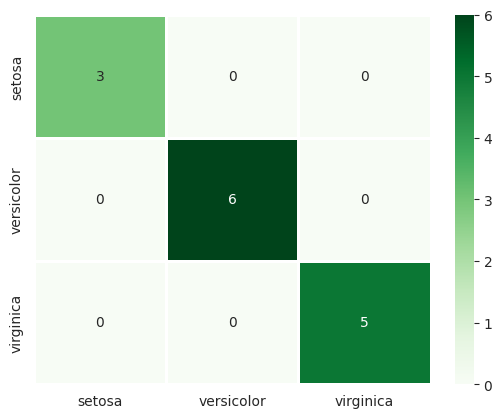

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(cm, cmap="Greens", linewidths=0.8, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()